In [1]:
import numpy as np
from APE import APE
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from sklearn.linear_model import LinearRegression as LR
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from data_processing import data_processing
%matplotlib inline

In [ ]:
df_train = pd.read_csv('run_data_trained.csv')
df_train

In [ ]:
y = df_train['Sweep Time']
features = df_train.iloc[:,0:15]

The purpose of this notebook is to confirm our suspisions that the current data set is sparse. To do this, multi linear regression coefficients will be analyzed. Large coefficients (relative to the other coefficients) is an indication that the matrix used in the OLS regression is close to a singular matrix, which happens when a variable(s) create rows in the matrix that are linearly dependent on the others. This occurs when there is little or no variance in a variable. 

Lets visualize all the data.

In [ ]:
for label in features.columns:
    plt.scatter(features[label],y,marker='o')
    plt.title(label+' vs Sweep time')
    plt.show()

We see that Nm, Np, Px, Py, and Pz contain no variance. As such, they will be removed from the data set. 

In [ ]:
drop_list = ['Nm','Np','Px','Py','Pz','Ag']
features = features.drop(drop_list,axis=1)
features.head()

Now we will look at the coefficients from a multi linear regression.

In [ ]:
model = LR()
model.fit(features,y)
print('R^2')
print(model.score(features,y))
print('Slopes')
print(model.coef_)

Above we see that the coefficients associated with Ng and Ag are much greater than the others. This is evidence of sparsity in the data set. 

In [ ]:
predictions = model.predict(features)
deltas = np.abs(predictions - y)
mean = np.mean(deltas)*np.ones(y.shape[0])
x = np.linspace(1,y.shape[0],y.shape[0])
plt.semilogy(x,deltas,'o')
plt.plot(x,mean)
plt.grid()

There are some outliers that we fit very very well, byt there are more outliers that we are fitting poorly (the minority group that lies between 10^1 and 10^2). This error could be from a linear model not being good enough or from a sparse data set. If we try and fit an ANN, and get the same error distribution, then we will need to add data points to our set. 

# ANN Tests

In [ ]:
sigmoid = lambda x:  1/(1+np.exp(-x))
feature_matrix,y,x_bar,x_std,y_bar,y_std = data_processing.input_generator('run_data_trained.csv')
#val_struct = data_processing.input_generator('serial_val_data.csv')
#val_x = val_struct[0]
#val_y = val_struct[1]
network = APE(sigmoid(feature_matrix),sigmoid(y),hidden_activation='elu',output_activation='sigmoid')
grid = np.array([10,40,40,1])
network.train(grid,200000,'time',loud=1)

In [ ]:
feature_matrix,y,x_bar,x_std,y_bar,y_std = data_processing.input_generator('run_data_trained.csv')
output = network.predict(sigmoid(feature_matrix),'time')
#un do the sigmoid activation function
output = -np.log((1/output) - 1)
#un normalize
output = (output*y_std) + y_bar
y = (y*y_std) + y_bar
print(output)
print(y)
delta = np.abs(output.T - y)
print(np.max(delta))

In [ ]:
x = np.linspace(1,y.shape[0],y.shape[0])
mean = np.mean(delta)*np.ones(y.shape[0])
print(mean)
plt.semilogy(x,delta.T,'o',label='Absolute Error')
plt.plot(x,mean,label='Average Absolute Error')
plt.ylabel('Absolute Error (ns)')
plt.xlabel('PDT run')
plt.title('Absolute ANN Error')
plt.legend(loc='best')
plt.grid()
import csv
with open('ann_error.csv','w') as writefile:
    writer = csv.writer(writefile)
    for i in (delta):
        writer.writerow(i)

In [ ]:
df = pd.read_csv('test.csv')
print(df.shape)
feature_matrix = np.zeros((383,6)) #serial file is 383 by 6, parallel memory is 5617 by 7, parallel time is 1728 by 5
#5 becuase it has no Np and no scattering moments, parallel time has all of them, and serial has no Np
y = np.array([])
features = df.iloc[0:383].values
for i in range(383):
    feature_matrix[i][0] = features[i][4]
    feature_matrix[i][1] = features[i][9]
    feature_matrix[i][2] = features[i][10]
    feature_matrix[i][3] = features[i][11]
    feature_matrix[i][4] = features[i][12]
    feature_matrix[i][5] = features[i][14] #only included for parallel memory and serial
    y = np.append(y,features[i][17])
x_bar = np.mean(feature_matrix,axis=0)
x_std = np.std(feature_matrix,axis=0)
y_bar = np.mean(y)
y_std = np.std(y)
print(x_bar)
print(x_std)
#normalize
feature_matrix = (feature_matrix-x_bar)/x_std
y = (y - y_bar)/y_std
val_x = feature_matrix[30]
val_x = val_x.reshape(1,6)
val_y = np.array([y[30]])
feature_matrix = np.delete(feature_matrix,30,axis=0)
y = np.delete(y,30)
sigmoid = lambda x:  1/(1+np.exp(-x))
network = APE(sigmoid(feature_matrix),sigmoid(y),val_x = sigmoid(val_x),val_y = sigmoid(val_y),hidden_activation='elu',output_activation='sigmoid',)
grid = np.array([5,20,20,20,20,40,1]) 
histroy = network.train(grid,30000000,'time',loud=0)

In [ ]:
output = network.predict(sigmoid(feature_matrix),'time')
#un do the sigmoid activation function
output = -np.log((1/output) - 1)
#un normalize
output = (output*y_std) + y_bar
y = (y*y_std) + y_bar
delta = np.abs(output.T-y)

In [ ]:
x = np.linspace(1,y.shape[0],y.shape[0])
mean = np.mean(delta)*np.ones(y.shape[0])
print(np.max(delta))
print(mean[0])
plt.semilogy(x,delta.T,'o',label='Absolute Error')
plt.plot(x,mean,label='Average Absolute Error')
plt.ylabel('Absolute Error (ns)')
plt.xlabel('PDT run')
plt.title('Absolute ANN Error')
plt.legend(loc='best')
plt.grid()
plt.show()
loss = np.array([histroy.history['loss']])
val_loss = np.array([histroy.history['val_loss']])
#build a quadratic for loss and val loss
A = np.zeros((np.size(loss),3))
x = np.linspace(1,np.size(loss),np.size(loss))
for i in range(np.size(loss)):
    A[i][0] = x[i]**2
    A[i][1] = x[i]
    A[i][2] = 1
M = np.dot(A.T,A)
b_l = np.dot(A.T,loss.T)
b_vl = np.dot(A.T,val_loss.T)
loss_coeff = np.linalg.solve(M,b_l)
val_loss_coeff = np.linalg.solve(M,b_vl)
loss_func = lambda x:loss_coeff[0]*x**2 + loss_coeff[1]*x + loss_coeff[2]
val_loss_func = lambda x:val_loss_coeff[0]*x**2 + val_loss_coeff[1]*x + val_loss_coeff[2]
#plt.plot(x,val_loss.T,'o',label='val_loss')
plt.plot(x,loss.T,label='loss')
plt.yscale('log')
#plt.plot(x,val_loss_func(x),label='val_loss quad fit')
#plt.plot(x,loss_func(x),label='loss quad fit')
plt.legend(loc='best')
print(loss)

# 2

In [5]:
df = pd.read_csv('parallel_data.csv')
y = np.array([])
feature_matrix = np.zeros((5617,12))
features = df.iloc[0:5617].values
for i in range(5617):
    feature_matrix[i][0] = features[i][0]
    feature_matrix[i][1] = features[i][1]
    feature_matrix[i][2] = features[i][2]
    feature_matrix[i][3] = features[i][4]
    feature_matrix[i][4] = features[i][6]
    feature_matrix[i][5] = features[i][7]
    feature_matrix[i][6] = features[i][8]
    feature_matrix[i][7] = features[i][9]
    feature_matrix[i][8] = features[i][10]
    feature_matrix[i][9] = features[i][11]
    feature_matrix[i][10] = features[i][12]
    feature_matrix[i][11] = features[i][14] 
    y = np.append(y,features[i][17])
x_bar = np.mean(feature_matrix,axis=0)
x_std = np.std(feature_matrix,axis=0)
y_bar = np.mean(y)
y_std = np.std(y)
print(x_bar)
print(x_std)
#normalize
feature_matrix = (feature_matrix-x_bar)/x_std
y = (y - y_bar)/y_std
val_x = feature_matrix[30]
val_x = val_x.reshape(1,12)
val_y = np.array([y[30]])
feature_matrix = np.delete(feature_matrix,30,axis=0)
y = np.delete(y,30)
#purge outliers, remove anything more than two standard deviations away from the average
delete_vec = np.array([])
for i in range(np.size(y)):
    if y[i] > 2:
        delete_vec = np.append(delete_vec,i)
y = np.delete(y,delete_vec,axis=0)
feature_matrix = np.delete(feature_matrix,delete_vec,axis=0)
sigmoid = lambda x:  1/(1+np.exp(-x))
network = APE(sigmoid(feature_matrix),sigmoid(y),val_x = sigmoid(val_x),val_y = sigmoid(val_y),hidden_activation='elu',output_activation='sigmoid',)
grid = np.array([12,100,100,100,100,100,1]) 
histroy = network.train(grid,30000000,'time',loud=0)

[25.02260993 25.02260993 25.02260993 13.9976856   3.18034538  3.18034538
  3.18034538  4.18461812  4.18461812  4.18461812  7.99875378  4.99928788]
[ 9.09270327  9.09270327  9.09270327 12.99999979  1.85279479  1.85279479
  1.85279479  4.03142258  4.03142258  4.03142258  7.81011281  3.99999994]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Epoch 1240137: early stopping


In [6]:
output = network.predict(sigmoid(feature_matrix),'time')
#un do the sigmoid activation function
output = -np.log((1/output) - 1)
#un normalize
output = (output*y_std) + y_bar
y = (y*y_std) + y_bar
delta = np.abs(output.T-y)

2.649983515625081
0.41559925174123075


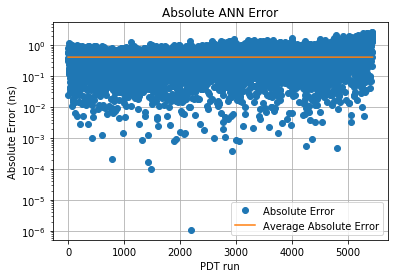

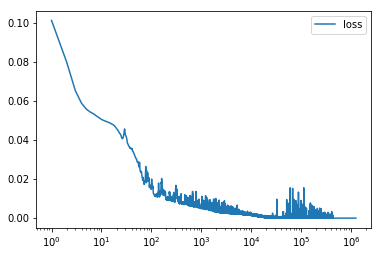

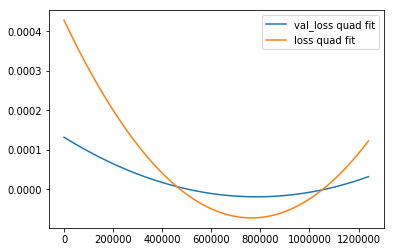

In [10]:
x = np.linspace(1,y.shape[0],y.shape[0])
mean = np.mean(delta)*np.ones(y.shape[0])
print(np.max(delta))
print(mean[0])
plt.semilogy(x,delta.T,'o',label='Absolute Error')
plt.plot(x,mean,label='Average Absolute Error')
plt.ylabel('Absolute Error (ns)')
plt.xlabel('PDT run')
plt.title('Absolute ANN Error')
plt.legend(loc='best')
plt.grid()
plt.show()
loss = np.array([histroy.history['loss']])
val_loss = np.array([histroy.history['val_loss']])
#build a quadratic for loss and val loss
A = np.zeros((np.size(loss),3))
x = np.linspace(1,np.size(loss),np.size(loss))
for i in range(np.size(loss)):
    A[i][0] = x[i]**2
    A[i][1] = x[i]
    A[i][2] = 1
M = np.dot(A.T,A)
b_l = np.dot(A.T,loss.T)
b_vl = np.dot(A.T,val_loss.T)
loss_coeff = np.linalg.solve(M,b_l)
val_loss_coeff = np.linalg.solve(M,b_vl)
loss_func = lambda x:loss_coeff[0]*x**2 + loss_coeff[1]*x + loss_coeff[2]
val_loss_func = lambda x:val_loss_coeff[0]*x**2 + val_loss_coeff[1]*x + val_loss_coeff[2]
#plt.plot(x,val_loss.T,'o',label='val_loss')
plt.plot(x,loss.T,label='loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()
plt.plot(x,val_loss_func(x),label='val_loss quad fit')
plt.plot(x,loss_func(x),label='loss quad fit')
plt.legend(loc='best')
plt.show()